In [1]:
import sys
import os

sys.path.append(os.environ['GADGETRON_HOME'] + '/share/gadgetron/python')

#If Gadgetron is not installed, add the path from the gadgetron source folder
#Set GADGETRON_SOURCE to point to the location of the Gadgetron source code
#sys.path.append(os.environ['GADGETRON_SOURCE'] + '/gadgets/python/utils')
#sys.path.append(os.environ['GADGETRON_SOURCE'] + '/gadgets/python/gadgets')

import ismrmrd
import ismrmrd.xsd
import numpy as np
from ismrmrdtools import show
from gadgetron import Gadget
from gadgetron import gadget_chain_wait
from gadgetron import gadget_chain_config
from gadgetron import get_last_gadget
from tpat_snr_scale import RemOS, NoiseAdj, PCA, CoilReduce, Recon

%matplotlib inline

In [2]:
def define_gadget_chain():
    g2 = Recon()
    g1 = RemOS(next_gadget=g2)
    g0 = CoilReduce(next_gadget=g1)
    gb = PCA(next_gadget=g0)
    ga = NoiseAdj(next_gadget=gb)    
    return ga

In [11]:
data_folder = os.environ['HOME'] + '/data/snr_test'
filename = data_folder + '/meas_MID00140_FID37475_CV_Gadgetron_FL_TPAT2_60REP.h5'
if not os.path.isfile(filename):
    print("%s is not a valid file" % filename)
    raise SystemExit

In [12]:
dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

In [13]:
g_python = define_gadget_chain()

In [14]:
# Send in data
#First ISMRMRD XML header
gadget_chain_config(g_python,dset.read_xml_header())

# Loop through the rest of the acquisitions and stuff
for acqnum in range(0,dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    g_python.process(acq.getHead(),acq.data.astype('complex64'))

# Wait for recon to finish
gadget_chain_wait(g_python)

In [15]:
res_python = get_last_gadget(g_python).get_results()
gmap = get_last_gadget(g_python).gmap

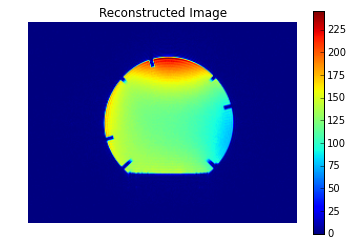

In [16]:
show.imshow(abs(np.squeeze(res_python[0][1])),colorbar=True,titles=['Reconstructed Image'])

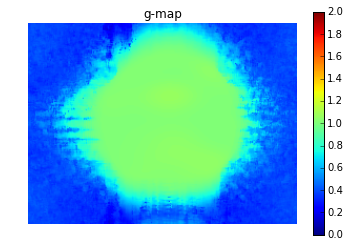

In [17]:
show.imshow(abs(np.squeeze(gmap)),colorbar=True,scale=(0,2.0),titles=['g-map'])